# Proyecto final
## Proceso de reversión a la media
_Juliana Vallejo, Paola Fernández, María Camila Vásquez_

In [5]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats
from statsmodels.stats.diagnostic import lilliefors
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

**Lectura de datos**

In [24]:
X1 = pd.read_csv('datos.csv')['H']
X = X1.reindex(index=X1.index[::-1])
X = np.array(X)
N = len(X)
R = X1.reindex(index=X1.index[::-1]).diff()
R = np.array(R[1:])

**Gráfica de la acción**

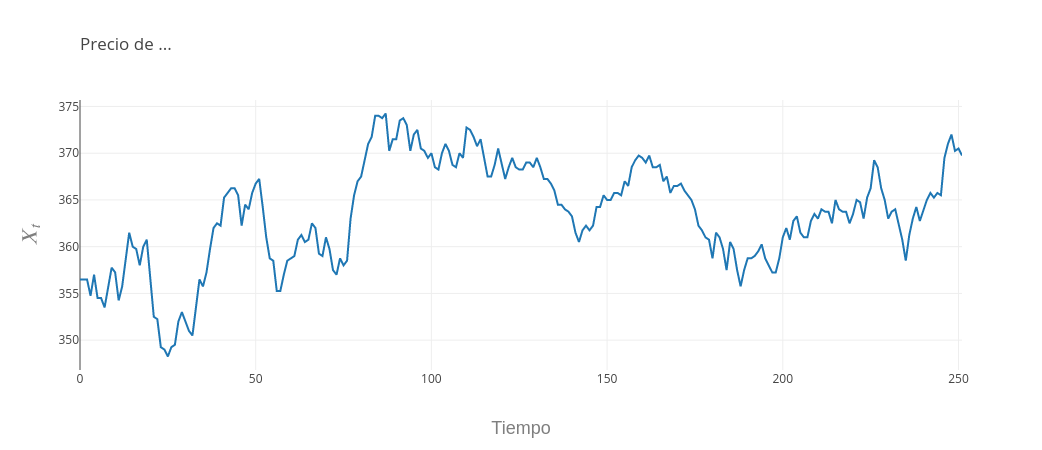

In [7]:
trace1 = go.Scatter(
    y = X,
    x = np.arange(N),
    name = '$X_1$'
)

data = [trace1]
layout = go.Layout(
    title=go.layout.Title(
        text='Precio de ...',
        xref='paper',
        x=0
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text='Tiempo',
            font=dict(
                family='Arial',
                size=18,
                color='#7f7f7f'
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='$X_t$',
            font=dict(
                family='Arial',
                size=18,
                color='#7f7f7f'
            )
        )
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Accion')

**Gráfica de la diferencia**

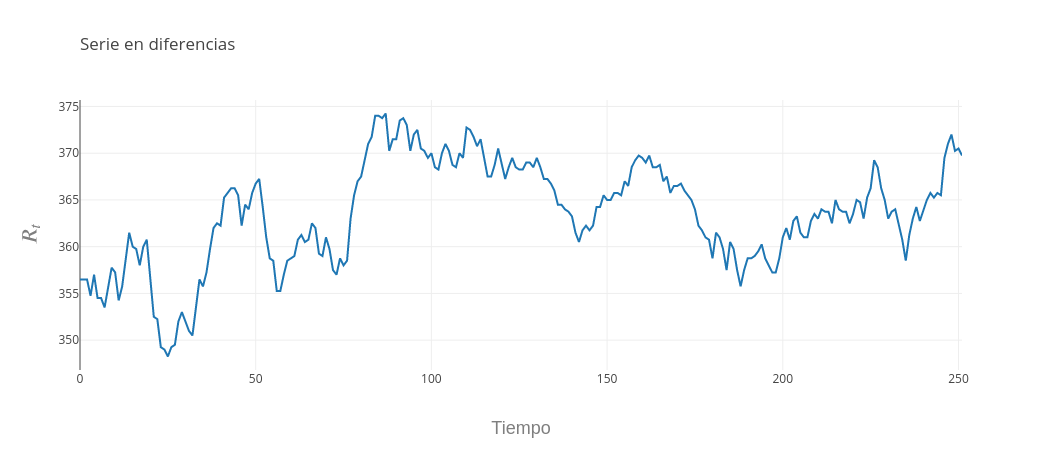

In [8]:
trace1 = go.Scatter(
    y = X,
    x = np.arange(N),
    name = '$R_t$'
)

data = [trace1]
layout = go.Layout(
    title=go.layout.Title(
        text='Serie en diferencias',
        xref='paper',
        x=0
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text='Tiempo',
            font=dict(
                family='Arial',
                size=18,
                color='#7f7f7f'
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='$R_t$',
            font=dict(
                family='Arial',
                size=18,
                color='#7f7f7f'
            )
        )
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Retornos')

**Test de normalidad**

In [9]:
jb = stats.jarque_bera(R)
lilie = lilliefors(R)
shapiro = stats.shapiro(R)

In [15]:
df = pd.DataFrame()
df['Jarque Bera'] = [jb[1]]
df['Shapiro Wilks'] = [shapiro[1]]

In [16]:
def hFD(a, k_max): 
# Higuchi FD
    L = []
    x = []
    N = len(a)

    for k in range(1,k_max):
        Lk = 0
        for m in range(0,k):
            #we pregenerate all idxs
            idxs = np.arange(1,int(np.floor((N-m)/k)),dtype=np.int32)
            Lmk = np.sum(np.abs(a[m+idxs*k] - a[m+k*(idxs-1)]))
            Lmk = (Lmk*(N - 1)/(((N - m)/ k)* k)) / k
            Lk += Lmk

        L.append(np.log(Lk/(m+1)))
        x.append([np.log(1.0/ k), 1])

    (p, r1, r2, s)=np.linalg.lstsq(x, L)
    return p[0]

In [17]:
def hurst(signal):
    tau = []; lagvec = []

    #  Step through the different lags
    for lag in range(2,20):

    #  produce price difference with lag
        pp = np.subtract(signal[lag:],signal[:-lag])

    #  Write the different lags into a vector
        lagvec.append(lag)

    #  Calculate the variance of the difference vector
        tau.append(np.std(pp))

    #  linear fit to double-log graph (gives power)
    m = np.polyfit(np.log10(lagvec),np.log10(tau),1)

    # calculate hurst
    hurst = m[0]

    return hurst

In [18]:
df['Coeficiente de Hurst'] = hurst(X)
df['Dimensión Fractal'] = hFD(X, 8)

In [19]:
print(df.to_latex(index=False))

\begin{tabular}{rrrr}
\toprule
 Jarque Bera &  Shapiro Wilks &  Coeficiente de Hurst &  Dimensión Fractal \\
\midrule
    0.963824 &       0.427923 &              0.476449 &           1.503126 \\
\bottomrule
\end{tabular}



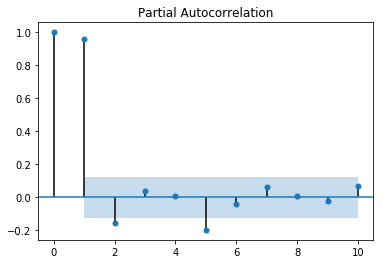

In [20]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(X,lags=10)
plt.show()

**Estimación de parámetros**

In [21]:
gamma = 1

In [22]:
A = np.sum(np.array([(X[i]*X[i-1])/(X[i-1]**(2*gamma)) for i in range(1,N)]))
B = np.sum(np.array([(X[i-1])/(X[i-1]**(2*gamma)) for i in range(1,N)]))
C = np.sum(np.array([(X[i])/(X[i-1]**(2*gamma)) for i in range(1,N)]))
D = np.sum(np.array([1/(X[i-1]**(2*gamma)) for i in range(1,N)]))
E = np.sum(np.array([(X[i-1]/(X[i-1]**(gamma)))**2 for i in range(1,N)]))

In [23]:
dt = 1/250
alphae = (E*D - B**2 - A*D + B*C)/((E*D - B**2)*dt)
mue = (A - E*(1 - alphae*dt))/(alphae*B*dt)
sigmae = [((X[i] - X[i-1] - alphae*(mue - X[i-1])*dt)/(X[i-1]**gamma))**2 for i in range(1,N)]
sigmae = np.sqrt((1/(N*dt))*np.sum(sigmae))
print(' alpha:', alphae, '\n', 'sigma:', sigmae, '\n', 'mu:', mue)
alpha = alphae
mu = mue
sigma = sigmae

 alpha: 9.383344230506466 
 sigma: 0.06563612599443787 
 mu: 364.8596937738987


In [25]:
# Parametros
dt = 1/252
# Condicion inicial
X0 = X[0]
# Numero de trayectorias
k = 100
S = np.zeros((k,N))
ms = []
for i in range(k):
    S[i,0] = X0
for i in range(k):
    errr=[]
    for j in range(1,N):
        S[i,j] = X[j-1] + alpha*(mu - X[j-1])*dt + sigma*X[j-1]**gamma*np.sqrt(dt)*np.random.normal()
        errr.append(np.abs(S[i,j]-X[j])/X[j])
    ms.append(np.mean(errr))

In [26]:
error = np.mean(ms)
error

0.004672829478450408

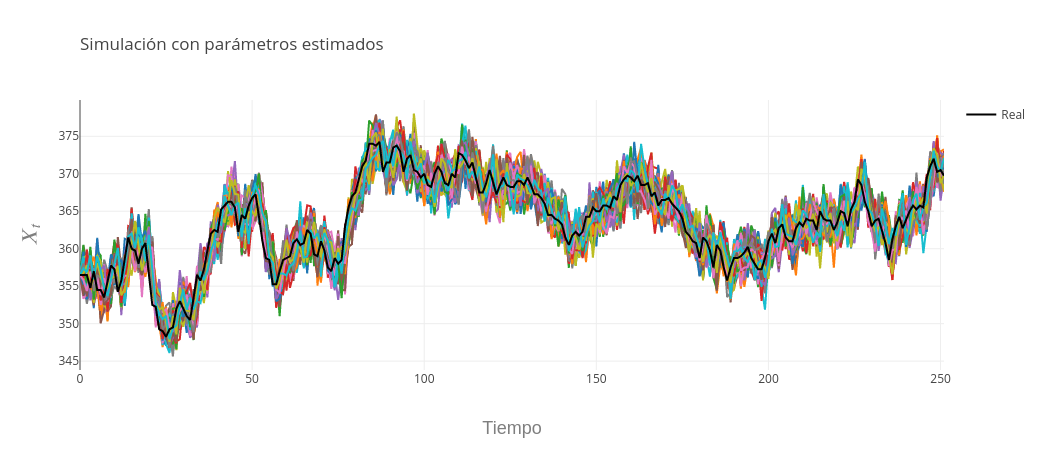

In [27]:
data=[]
for i in range(k):
    trace1 = go.Scatter(
        y = S[i],
        x = np.arange(N),
        showlegend=False
    )
    data.append(trace1)

trace2 = go.Scatter(
    y = X,
    x = np.arange(N),
    mode = 'lines',
    line = dict(color = 'rgb(0,0,0)'),
    name = 'Real'
)
data.append(trace2)
layout = go.Layout(
    title=go.layout.Title(
        text='Simulación con parámetros estimados',
        xref='paper',
        x=0
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text='Tiempo',
            font=dict(
                family='Arial',
                size=18,
                color='#7f7f7f'
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='$X_t$',
            font=dict(
                family='Arial',
                size=18,
                color='#7f7f7f'
            )
        )
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Estimacion')

*Opciones*

In [37]:
# Parametros
# condicion inicial
S0 = X[-1]
# Tasa de interés libre de riesgo
r = 0.05
# Precio de ejercicio
K = 0.9*S0

In [38]:
K

332.77500000000003

In [39]:
op = pd.DataFrame()

In [40]:
# Simulación montecarlo
def montecarlo(T):
    k = 100
    M = 200
    N = 250
    dt = T/N
    S = np.zeros([k,N]) # Filas cada tracyectoria, columnas el tiempo
    payoff=np.zeros(k) #en cada simulacion saco el payoff de cada trayectoria
    opcion=np.zeros(M) #Tantas opciones como simulaciones
    for h in range(M):
        for i in range(k):
            S[i,0] = S0
        for i in range(k):
            for t in range(N-1):
                S[i,t+1]=S[i,t]+r*S[i,t]*dt+sigma*np.sqrt(dt)*np.random.normal()
            payoff[i]=np.max([S[i,N-1]-K,0]) 
        opcion[h]=np.exp(-r*T)*np.mean(payoff); 
    opcionmedio = np.mean(opcion)
    return opcionmedio

In [41]:
# Árboles binomiales
def binomial(T):
    n = 50
    dt = T/n
    arbol = np.zeros((N+1,N+1))
    arbol[0,0] = S0
    for i in range(N):
        for j in range(i+1):
            u = np.exp(sigma*np.sqrt(dt)/arbol[i,j])
            d = 1/u
            arbol[i+1,j]   = arbol[i,j]*d
            arbol[i+1,j+1] = arbol[i,j]*u
    f = np.zeros((N+1,N+1))
    for j in range(N+1):
        f[N,j] = np.maximum(arbol[N,j] - K,0)
    for i in range(N-1,-1,-1):
        for j in range(i+1):
            p = 1/2 + (r-1/2*(sigma/arbol[i,j])**2)*np.sqrt(dt)/(2*sigma/arbol[i,j])
            f[i,j] = np.exp(-r*dt)*(p*f[i+1,j+1] + (1-p)*f[i+1,j])
    return f[0,0]

In [42]:
# Diferen
def diferencias(T):
    Smax = 2*S0
    dS = 0.01
    M = int(np.ceil(Smax/dS))
    dt = dS**2/sigma**2
    N = int(np.ceil(T/dt))
    dt = T/N
    f = np.zeros((N+1,M+1))
    f[:,0] = 0
    f[:,M] = Smax - K
    for j in range(M):
        f[N,j] = np.max([j*dS-K,0])
    a = np.zeros(M+1)
    b = np.zeros(M+1)
    c = np.zeros(M+1)
    for j in range(M+1):
        a[j] = (dt/(1+r*dt)) * ((sigma**2)/(2*dS**2) - (r * j/2))
        b[j] = (dt/(1+r*dt)) * ((1/dt) - sigma**2/dS**2)
        c[j] = (dt/(1+r*dt)) * ((sigma**2)/(2*dS**2) + (r * j/2))

    for i in reversed(range(N)):
        for j in reversed(range(1, M)):
            f[i,j] = a[j] * f[i+1, j-1] + b[j] * f[i+1, j] + c[j] * f[i+1, j+1]
    S = np.arange(0, Smax+dS, dS)
    t = np.arange(0, T+dt, dt)
    P = S0//dS;
    FF = f[0,int(P)]
    return FF

In [43]:
aa = [1/4, 1/2, 1, 1/6]
from tqdm import tqdm
for t in tqdm(aa):
    rrr = []
    rrr.append(montecarlo(t))
    rrr.append(binomial(t))
    rrr.append(diferencias(t))
    rrr = pd.Series(rrr)
    op[t] = rrr

100%|██████████| 4/4 [01:34<00:00, 23.72s/it]


In [44]:
op.index = ['Simulación Montecarlo', 'Árboles binomiales', 'Diferencias Finitas']

In [45]:
print(op.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &     0.250000 &      0.500000 &      1.000000 &       0.166667 \\
\midrule
Simulación Montecarlo &    41.090373 &  4.515349e+01 &  5.312811e+01 &   3.972406e+01 \\
Árboles binomiales    &          inf &          -inf &           NaN &  8.888183e+291 \\
Diferencias Finitas   &  1802.317067 & -8.241545e+20 &  3.788050e+56 &   3.973337e+01 \\
\bottomrule
\end{tabular}



In [46]:
S0

369.75

In [47]:
sigma

0.06563612599443787